In [2]:
import traffic
import pandas as pd 
import os
import time
from traffic.core import Traffic
from sklearn.metrics import accuracy_score,f1_score,recall_score,balanced_accuracy_score,precision_score,plot_roc_curve,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import RidgeClassifier,LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from biblio_herramienta.herramienta import *
from biblio_herramienta.tratardatos import *
from biblio_herramienta.ml import *

In [3]:
archivoBBDD = r"/Users/jaimebowen/OneDrive/TFGSeptiembre/libros_a_scripts/datos_sectores/BBDD_bilbao.csv"

In [4]:
archivoPRUEBA = r"/Users/jaimebowen/OneDrive/TFGSeptiembre/libros/datos_sectores/datos_f_c_pares_bilbao_magnitudes.csv"

In [5]:
bbdd = pd.read_csv(archivoBBDD)

In [6]:
bbdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463080 entries, 0 to 463079
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          463080 non-null  int64  
 1   Unnamed: 0.1        463080 non-null  int64  
 2   ave1                463080 non-null  object 
 3   ave2                463080 non-null  object 
 4   Unnamed: 0_1        463080 non-null  int64  
 5   Unnamed: 0.1_1      463080 non-null  int64  
 6   Unnamed: 0.1.1_1    463080 non-null  int64  
 7   altitude_1          463080 non-null  float64
 8   geoaltitude_1       463080 non-null  float64
 9   groundspeed_1       463080 non-null  float64
 10  latitude_1          463080 non-null  float64
 11  longitude_1         463080 non-null  float64
 12  timestamp_1         463080 non-null  object 
 13  track_1             463080 non-null  float64
 14  vertical_rate_1     463080 non-null  float64
 15  track_unwrapped_1   463080 non-nul

In [7]:
cols = [0,1,2,3,4,5,6,8,12,13,16,17,18,21,25,26,19,29,37,38]
bbdd.drop(bbdd.columns[cols],axis=1,inplace= True)
bbdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463080 entries, 0 to 463079
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   altitude_1          463080 non-null  float64
 1   groundspeed_1       463080 non-null  float64
 2   latitude_1          463080 non-null  float64
 3   longitude_1         463080 non-null  float64
 4   vertical_rate_1     463080 non-null  float64
 5   track_unwrapped_1   463080 non-null  float64
 6   altitude_2          463080 non-null  float64
 7   groundspeed_2       463080 non-null  float64
 8   latitude_2          463080 non-null  float64
 9   longitude_2         463080 non-null  float64
 10  vertical_rate_2     463080 non-null  float64
 11  track_unwrapped_2   463080 non-null  float64
 12  Init separation     463080 non-null  float64
 13  Init acimut         463080 non-null  float64
 14  Var GS Module       463080 non-null  float64
 15  Var Track           463080 non-nul

In [8]:
bbdd.Conflicto.value_counts()

0    462963
1       117
Name: Conflicto, dtype: int64

In [9]:
bbdd["Diff lat"] = bbdd["latitude_1"] -bbdd["latitude_2"] 

In [10]:
bbdd["Diff long"] = bbdd["longitude_1"] - bbdd["longitude_2"] 
bbdd["Diff alt"] = bbdd["altitude_1"] - bbdd["altitude_2"] 

In [11]:
bbdd.head()

,altitude_1,groundspeed_1,latitude_1,longitude_1,vertical_rate_1,track_unwrapped_1,altitude_2,groundspeed_2,latitude_2,longitude_2,...,Init separation,Init acimut,Var GS Module,Var Track,Var init altitude,Var Vertical speed,Conflicto,Diff lat,Diff long,Diff alt
0,35025.0,487.0,44.375129,-3.97484,-64.0,187.314737,36000.0,434.0,42.770194,-4.927751,...,104.868237,-156.321253,912.002645,163.942628,-975.0,-64.0,0,1.604935,0.952911,-975.0
1,35025.0,487.0,44.375129,-3.97484,-64.0,187.314737,35000.0,449.0,44.375362,-3.949183,...,1.104216,89.266358,50.057158,3.993261,25.0,-64.0,0,-0.000233,-0.025657,25.0
2,35025.0,487.0,44.375129,-3.97484,-64.0,187.314737,36000.0,415.0,42.335303,-2.947657,...,130.363624,159.469960,893.772561,164.460969,-975.0,-64.0,0,2.039826,-1.027183,-975.0
3,35025.0,487.0,44.375129,-3.97484,-64.0,187.314737,39000.0,402.0,44.374617,-3.978391,...,0.155850,-101.368558,85.107283,-0.553190,-3975.0,-64.0,0,0.000512,0.003550,-3975.0
4,35025.0,487.0,44.375129,-3.97484,-64.0,187.314737,34525.0,421.0,42.363561,-3.227362,...,125.026066,164.574815,907.033171,174.697396,500.0,-960.0,0,2.011569,-0.747478,500.0


# 2. Generación de los datatsets
Con los datos cargados, ahora se van a generar dos BBDD:
* La que se va a usar para entrenar al modelo
* La que se va a usar para saber si el modelo ha sido bien entrenado

In [12]:
X = bbdd.drop(columns = ["Conflicto","altitude_1","altitude_2","latitude_1","latitude_2","longitude_2","longitude_1"],axis =1)
y = bbdd["Conflicto"].to_numpy()
lb = LabelBinarizer()
y = lb.fit_transform(y).ravel()




from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , y , stratify = y, test_size = 0.2, random_state = 42)

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463080 entries, 0 to 463079
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   groundspeed_1       463080 non-null  float64
 1   vertical_rate_1     463080 non-null  float64
 2   track_unwrapped_1   463080 non-null  float64
 3   groundspeed_2       463080 non-null  float64
 4   vertical_rate_2     463080 non-null  float64
 5   track_unwrapped_2   463080 non-null  float64
 6   Init separation     463080 non-null  float64
 7   Init acimut         463080 non-null  float64
 8   Var GS Module       463080 non-null  float64
 9   Var Track           463080 non-null  float64
 10  Var init altitude   463080 non-null  float64
 11  Var Vertical speed  463080 non-null  float64
 12  Diff lat            463080 non-null  float64
 13  Diff long           463080 non-null  float64
 14  Diff alt            463080 non-null  float64
dtypes: float64(15)
memory usage: 53.0 

In [35]:
y

array([0, 0, 0, ..., 0, 0, 0])

# 3. Generación de Pipelines 
Como se comenta en el apartado 2 el TFG, se va a usar varios método para realizar las predicciones de los datos obtenidos y probar cual es aquel que tiene mayor precisión.  


## 3.1 Modelos lineales

In [41]:
# Clasificador Ridge

ridge_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('ridge_classifier',RidgeClassifier(alpha = 0.5))
])


# Clasificador Logísitico

logistic_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('logistic_classifier',LogisticRegression(random_state = 55))
])

# Clasificador Gradiante Estocastico

sgdc_pipe = Pipeline((
    ('scaler', StandardScaler()),
    ('linear_sgdc', SGDClassifier(random_state = 55)))
)


#pipes = [ridge_pipe ,logistic_pipe ,svm_pipe ,sgdc_pipe , kvecinos_pipe, gauss_pipe, bayes_pipe, arbol_pipe]
lin_pipes = [ridge_pipe ,logistic_pipe ,sgdc_pipe]

In [44]:
nombres_algoritmos_lineal = ["Ridge","Logistico","SGD"]
dlineal = metricasp(lin_pipes,X_train, y_train,nombres_algoritmos_lineal)
dlineal.to_csv("modelos_ml/dlineal.csv")
dlineal

/Users/jaimebowen/opt/miniconda3/envs/tfgpaquetes/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaimebowen/opt/miniconda3/envs/tfgpaquetes/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaimebowen/opt/miniconda3/envs/tfgpaquetes/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Clasificador,Exactitud,Precision,Sensibilidad,F1
0,Ridge,0.999746,0.0,0.0,0.0
1,Logistico,0.999746,0.0,0.0,0.0
2,SGD,0.999746,0.0,0.0,0.0


# 3.2 SVM

In [24]:
from sklearn.svm import LinearSVC,SVC

svm_lineal_pipe = Pipeline((
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(random_state = 55,max_iter=4000))
    
))


svm_pipe = Pipeline((
    ('scaler', StandardScaler()),
    ('svc',SVC(random_state = 55,gamma = "auto"))
))
pipes_svm = [svm_lineal_pipe,svm_pipe ]

In [ ]:
start_time = time.time()
pipes_svm_entrenadas=[]
for index, i in enumerate(pipes_svm):
    i.fit(X_train,y_train)
    pipes_svm_entrenadas.append(i)
    
print("--- %s seconds ---" % (time.time() - start_time))

In [47]:
nombres_algoritmos_svm = ["SVM Lineal","SVM Estandar"]
dsvm = metricas(pipes_svm_entrenadas,X_test,y_test,nombres_algoritmos_svm)
dsvm.to_csv("modelos_ml/dsvm.csv")
dsvm

/Users/jaimebowen/opt/miniconda3/envs/tfgpaquetes/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaimebowen/opt/miniconda3/envs/tfgpaquetes/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
for i in pipes_svm_entrenadas:
    y_train_pred = cross_val_predict(i, X_train, y_train, cv=7)
    print(confusion_matrix(y_train, y_train_pred))

[[370370      0]
 [    94      0]]
[[370370      0]
 [    94      0]]


## 3.3 Clasificador vecinos cercanops

In [13]:
# Clasificador Veciones cercanos

kvecinos_pipe = Pipeline((
    ('scaler', StandardScaler()),
    ('kveciones_clas', KNeighborsClassifier(weights= "distance"))
))

kvecinos_pipe1 = Pipeline((
    ('scaler', StandardScaler()),
    ('kveciones_clas', KNeighborsClassifier())
))

kvecinos_pipes =[kvecinos_pipe,kvecinos_pipe1]

In [14]:
start_time = time.time()
pipes_kvecinos_entrenadas=[]
for index, i in enumerate(kvecinos_pipes):
    i.fit(X_train,y_train)
    pipes_kvecinos_entrenadas.append(i)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 293.16506814956665 seconds ---


In [15]:
nombres_algoritmos_kvecino = ["Vecinos Cercanos Dist","Vecinos Cercanos Weight"]
dkvecinos = metricas(pipes_kvecinos_entrenadas,X_test,y_test,nombres_algoritmos_kvecino)
dkvecinos.to_csv("modelos_ml/dvcerca.csv")
dkvecinos

/Users/jaimebowen/opt/miniconda3/envs/tfgpaquetes/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
for i in pipes_kvecinos_entrenadas:
    y_train_pred = cross_val_predict(i, X_train, y_train, cv=7)
    print(confusion_matrix(y_train, y_train_pred))

[[370359     11]
 [    94      0]]
[[370370      0]
 [    94      0]]


## 3.4 Clasificador por proceso gausiano

In [17]:
gauss_pipe = Pipeline((
    ('scaler', StandardScaler()),
    ('gauss_class', GaussianProcessClassifier(random_state = 55))
))
gauss_pipes = [gauss_pipe]

In [ ]:
gauss_pipe.fit(X_train,y_train)

In [ ]:
#start_time = time.time()
pipes_gauss_entrenados=[]
for index, i in enumerate(gauss_pipes):
    i.fit(X_train,y_train)
    pipes_gauss_entrenados.append(i)
    
#print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
nombres_algoritmos_gauss = ["Gauss"]
dgauss = metricas(pipes_gauss_entrenados,X_test,y_test,nombres_algoritmos_gauss )
dgauss.to_csv("modelos_ml/dgauss.csv")

## 3.5 Clasificación Naiva-Bayes

In [13]:
bayes_pipe = Pipeline((
    ('scaler', StandardScaler()),
    ('naive_class', GaussianNB()))
)
bayes_pipes = [bayes_pipe]

In [17]:
nombres_algoritmos_bayes = ["Naive-Bayes gaussiano"]
dbayes = metricas(bayes_pipes,X_train, y_train,nombres_algoritmos_bayes)
dbayes.to_csv("modelos_ml/dbayes.csv")
dbayes

,Clasificador,Exactitud,Precision,Sensibilidad,F1
0,Naive-Bayes gaussiano,0.969228,0.001499,0.180851,0.002974


In [23]:
pipes_bayes_entrenados=[]
for index, i in enumerate(bayes_pipes):
    i.fit(X_train,y_train)
    pipes_bayes_entrenados.append(i)

In [45]:
for i in bayes_pipes :
    y_train_pred = cross_val_predict(i, X_train, y_train, cv=7)
    print(confusion_matrix(y_train, y_train_pred))

[[359047  11323]
 [    77     17]]


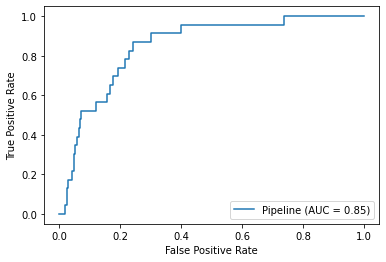

In [22]:
plot_roc_curve(pipes_bayes_entrenados[0], X_test, y_test)

## 3.6 Arbol de decisiones

In [18]:
arbol_pipe = Pipeline((
    ('scaler', StandardScaler()),
    ('arbol_class', DecisionTreeClassifier(random_state=55,)))
)
arbol_pipes = [arbol_pipe]

In [19]:
start_time = time.time()
pipes_arbol_entrenados=[]
for index, i in enumerate(arbol_pipes ):
    i.fit(X_train,y_train)
    pipes_arbol_entrenados.append(i)
    
print("--- %s seconds ---" % (time.time() - start_time))


--- 2.769727945327759 seconds ---


In [20]:
nombres_algoritmos_arbol = ["Arbol"]
darbol= metricas(pipes_arbol_entrenados,X_test,y_test,nombres_algoritmos_arbol )
darbol.to_csv("modelos_ml/darbol2.csv")
darbol

,Clasificador,Exactitud,Precision,Sensibilidad,F1
0,Arbol,0.999417,0.0,0.0,0.0


In [ ]:
for i in pipes_arbol_entrenados:
    y_train_pred = cross_val_predict(i, X_train, y_train, cv=7)
    print(confusion_matrix(y_train, y_train_pred))

In [ ]:
precision_score(y_train, y_train_pred)

In [ ]:
y_pred = arbol_pipe.predict(X_test)

In [ ]:
np.unique(y_pred)

In [ ]:
def curvaROC1(pipe,X_train,y_train):

    # representa la curva roc
    y_scores = cross_val_predict(pipe, X_train, y_train, cv=3)

    fpr, tpr, thresholds = roc_curve(y_train, y_scores)


    def plot_roc_curve(fpr, tpr, label=None):
        plt.plot(fpr, tpr, linewidth=2, label=label)
        #plt.plot([0, 1], [0, 1], 'k--')
        plt.axis([0, 1, 0, 1])
        plt.xlabel('Ratio de Falsos Positivos')
        plt.ylabel('Ratio de Verdaderos Positivos')

    plot_roc_curve(fpr, tpr)
    plt.show()
    

In [ ]:

plot_roc_curve(pipes_arbol_entrenados[0], X_test, y_test)

# Metrics

In [ ]:
ridge_pipe.fit(X_train,y_train)

In [ ]:
y_train.value_counts()

In [ ]:
accuracy_score(y_test,ridge_pipe.predict(X_test))

### 3.1.1 Clasificadro SVM

In [ ]:
svm_pipe.fit(X_train,y_train)

In [ ]:
accuracy_score(svm_pipe.predict(X_test),y_test)

In [ ]:
curvaROC(ridge_pipe,X_train,y_train)

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(ridge_pipe, X_train, y_train, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

In [ ]:
prue = pd.read_csv(archivoPRUEBA)

In [ ]:
prue.info()

In [ ]:
cols = [0,1,2,4,5,8,12,13,14,18,22]
y_prue_svm = ridge_pipe.predict(prue.drop(prue.columns[cols],axis=1))
prue["Conflicto_svm"] = y_prue_svm



In [ ]:
prue.head()

In [ ]:
X_train.info()